# Class Activation Map Examples for Image Classification

Much of the code in this blog was adapted from [Jacob Gil's Github repository for class activation mapping](https://github.com/jacobgil/keras-cam).

In [4]:
import warnings
warnings.filterwarnings('ignore')
import keras
import matplotlib.pyplot as plt
from keras.datasets import mnist # load in our MNIST dataset

In order to help with typing, we'll define some common shapes.

In [6]:
from typing import Tuple
import numpy as np
ImageShape = Tuple[int, int]
GrayScaleImageShape = Tuple[int, int, int] # a grayscale image should have a H x W x 1 dimensionality
Dataset = Tuple[np.ndarray, np.ndarray]

## Load in Data and Train/Test Splits
We first split the MNIST dataset into train and test splits, and print out their shapes.

In [7]:
#download mnist data and split into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(f"The shape of X_train is {X_train.shape}")
print(f"The shape of y_train is {y_train.shape}")
print(f"The shape of X_test is {X_test.shape}")
print(f"The shape of y_test is {y_test.shape} - some example targets: {y_test[:5]}")
mnist_image_shape: ImageShape = X_train.shape[1:]
print(mnist_image_shape)

The shape of X_train is (60000, 28, 28)
The shape of y_train is (60000,)
The shape of X_test is (10000, 28, 28)
The shape of y_test is (10000,) - some example targets: [7 2 1 0 4]
(28, 28)


## One-Hot Encode Categorical Targets

In [10]:
from keras.utils import to_categorical

OneHotEncodedTarget = np.ndarray
Categories = int
encoded_y_train: OneHotEncodedTarget = to_categorical(y_train)
encoded_y_test: OneHotEncodedTarget = to_categorical(y_test)
print(f"One-hot encoding y_train {y_train.shape} -> {encoded_y_train.shape}")
print(f"One-hot encoding y_test {y_test.shape} -> {encoded_y_test.shape}")

CLASSES: Categories = encoded_y_test.shape[1]

One-hot encoding y_train (60000,) -> (60000, 10)
One-hot encoding y_test (10000,) -> (10000, 10)


We'll also need to reshape the tensors and expand their dimensionality in order for Keras to accept their tensor shape as input. Essentially, this involves adding an extra dimension to the current tensor shape.

In [13]:
def expand_tensor_shape(X_train: np.ndarray)-> np.ndarray:
    new_shape: Tuple = X_train.shape + (1,)
    new_tensor = X_train.reshape(new_shape)
    print(f"Expanding shape from {X_train.shape} to {new_tensor.shape}")
    return new_tensor

X_train_expanded: np.ndarray = expand_tensor_shape(X_train)
X_test_expanded: np.ndarray = expand_tensor_shape(X_test)

Expanding shape from (60000, 28, 28) to (60000, 28, 28, 1)
Expanding shape from (10000, 28, 28) to (10000, 28, 28, 1)


## Build a Vanilla CNN Implementation (With No Attention / Class-Activation)

The vanilla architecture we will build as a baseline "Hello World" contains two 2D Convolutional layers, followed by a `Flatten` aggregation layer:
<img src="public/vanilla_architecture.png" width="500" height="400">

In [50]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, Input
from tensorflow.python.framework.ops import Tensor
import warnings
warnings.filterwarnings('ignore')

# define model architecture and hyperparameters
NUM_FILTERS_L1 = 64
NUM_FILTERS_L2 = 32
KERNEL_SIZE = 3

# the images are 28 x 28 (pixel size) x 1 (grayscale - if RGB, then 3)
input_dims: GrayScaleImageShape = (28,28,1)

def build_vanilla_cnn(filters_layer1:int, filters_layer2:int, kernel_size:int, input_dims: GrayScaleImageShape)-> Model:
    inputs: Tensor = Input(shape=input_dims)
    x: Tensor = Conv2D(filters=filters_layer1, kernel_size=kernel_size, activation='relu')(inputs)
    x: Tensor = Conv2D(filters=filters_layer2, kernel_size=kernel_size, activation='relu')(x)
    x: Tensor = Flatten()(x)
    predictions = Dense(CLASSES, activation="softmax")(x)
    print(predictions)

    #compile model using accuracy to measure model performance
    model: Model = Model(inputs=inputs, outputs=predictions)
    print(model.summary())
    model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
    return model

model: Model = build_vanilla_cnn(NUM_FILTERS_L1, NUM_FILTERS_L2, KERNEL_SIZE, input_dims)

Tensor("dense_5/Softmax:0", shape=(?, 10), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 32)        18464     
_________________________________________________________________
flatten_4 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                184330    
Total params: 203,434.0
Trainable params: 203,434.0
Non-trainable params: 0.0
_________________________________________________________________
None


## Optional: Run the Model
Keras will return a history object from the `model.fit()` call. This object contains training loss, validation loss, and the performance metrics you've selected to evaluate (in this case accuracy).

In [14]:
from keras.callbacks import History

RUN_VANILLA = False # set this to True to actually run the model

if RUN_VANILLA:
    history: History = model.fit(X_train_expanded, encoded_y_train, 
                                 validation_data=(X_test_expanded, encoded_y_test), epochs=2, batch_size=2058)

## Define a Class Activation Map for the CNN

In [23]:
from keras import backend as K
from keras.layers import Dense, Conv2D, Flatten, Input, MaxPool2D, Layer, Lambda
from tensorflow.python.framework.ops import Tensor
import cv2

def global_average_pooling(x: Layer):
    return K.mean(x, axis = (2,3))

def global_average_pooling_shape(input_shape):
    # return the dimensions corresponding with batch size and number of filters
    return (input_shape[0], input_shape[-1])

def build_global_average_pooling_layer(function, output_shape):
    return Lambda(pooling_function, output_shape)


### Model Architecture for Basic Class Activation Mapped CNN
<img src="public/cam_architecture.png" width="600" height="600">

The original `28x28` image has a depth of 1 (grayscale) and is mapped to 32 filter feature maps of size `24x24`. These are then aggregated in the global average pooling layer to 1 scalar value per feature map (32 feature maps in total $\rightarrow$ 32 scalar averages. These are then run through a dense softmax layer.

In [24]:
def build_class_activation_map_cnn()-> Model:
    '''
    I've commented out different internal layers of the CNN architecture. However, feel free to comment them back in to
    add more complexity to the model. Note that doing so may dramatically increase training time.
    '''

    inputs: Tensor = Input(shape=(28,28,1))
    x: Tensor = Conv2D(filters=32, 
                       kernel_size=5, 
                       activation='relu',
                       name='final_convolution_layer')(inputs)
    # x: Tensor = MaxPool2D()(x)
    # x: Tensor = Conv2D(filters=64, kernel_size=5, activation='relu')(x)
    x: Tensor = Lambda(lambda x: K.mean(x, axis=(1,2)), output_shape=global_average_pooling_shape)(x)
    # x: Tensor = Dense(128, activation="relu")(x)
    predictions: Tensor = Dense(10, activation="softmax")(x)
    model: Model = Model(inputs=inputs, outputs=predictions)
    model.summary()
    model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
    return model

def run_cnn_cam(model, save_filepath):
    history: History = model.fit(X_train_expanded, encoded_y_train, 
                                 validation_data=(X_test_expanded, encoded_y_test), epochs=100, batch_size=5126)

    model.save(save_filepath)

In [25]:
# do a dry run of the model construction to see its architecture and parameter distributions
build_class_activation_map_cnn()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
final_convolution_layer (Con (None, 24, 24, 32)        832       
_________________________________________________________________
lambda_1 (Lambda)            (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 1,162.0
Trainable params: 1,162.0
Non-trainable params: 0.0
_________________________________________________________________


Note that we purposely gave the final `Conv2D` layer an explicit name: `final_convolution_layer` - we do this so that after our model has finished training, we can explicitly call `model.get_layer(final_convolution_layer)` to grab that layer's outputs.

In [30]:
RUN_CAM = False
MODEL_FOLDER = "saved_models"
save_filepath: str = "basic_cam.h5"
    
import os
saved_model_relative_path: str = os.path.join(MODEL_FOLDER, save_filepath)
print(saved_model_relative_path)
if RUN_CAM:
    cam_model = build_class_activation_map_cnn()
    run_cnn_cam(cam_model, saved_model_relative_path)

saved_models\basic_cam.h5


## Load Persisted Model and Visualize Class Activation Maps

In [33]:
from keras.models import load_model
warnings.filterwarnings('ignore')
model = load_model(saved_model_relative_path)

## Define Function to Grab Outputs of a Particular Keras Layer

We need two main inputs:

1. The `class_weights`, which should be of dimension size `number of nodes in final feedforward layer x number of classes`. This is easy to get because we can simply call `model.layers[-1]` to retrieve the last layer in the model architecture, and then call `get_weights` to fetch the Numpy array of weights. Note that `get_weights` actually returns a list of two weight matrices - one for the incoming weights (which is what we care about) and the other the outbound weights (which aren't as useful for us in this case).


2. The **output of the final convolutional layer**. Since our model could be of any arbitrary depth, we need to get this particular layer by its name, which - if you remember - we conveniently labelled `final_convolutional_layer`.

In [36]:
def get_output_layer(model: Model, layer_name: str)-> Layer:
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer

## Visualize the Class Activation Maps for One Sample Image
We'll randomly pick the 6th image of the dataset and visualize it. It happens to be a 2.

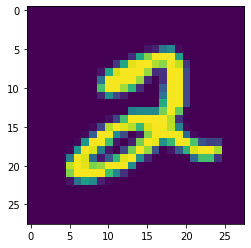

In [41]:
first_image = X_train[5]
first_image = first_image.reshape(28,28,1)
img = np.array(first_image).reshape(1, 28, 28, 1)
img.shape
plt.imshow(img.reshape((28,28)))

In [43]:
class_weights = model.layers[-1].get_weights()[0]

conv_layer_name = "conv2d_1" # I accidentally saved the model with this as the conv2d layer name - oops!
final_conv_layer = get_output_layer(model, "conv2d_1")

# define a Keras function to accept as input the model image input and return the final dense layer weights and
# convolution layer weights
get_output = K.function([model.layers[0].input], [final_conv_layer.output, model.layers[-1].output])

[conv_outputs, predictions] = get_output([img])
conv_outputs = conv_outputs[0,:,:,:]
print(f"Final convolution layer has outputs of {conv_outputs.shape}")
print(f"Final dense layer class weights have output of {class_weights.shape}") 

Final convolution layer has outputs of (24, 24, 32)
Final dense layer class weights have output of (32, 10)


## Define Function to Generate Class Activation Map

In [45]:
def make_cam(conv_outputs: np.ndarray, class_weights: np.ndarray, original_shape: Tuple[int, int], target_class: int):
    
    '''
    Our class activation map should be the same shape as the first two dimensions of our Conv2D output (24 x 24).
    We finally also need to interpolate our CAM back to the original image (which we do with cv2.resize)
    '''
    
    cam = np.zeros(dtype=np.float32, shape = conv_outputs.shape[0:2])

    # we select ONLY the weight vectors from our class weight matrix (of size 32 x 10) that apply to the target class
    # that we care about (in this case, 2)
    for i, w in enumerate(class_weights[:, target_class]):
        cam += w * conv_outputs[:,:,i]
    cam /= np.max(cam)
    return cv2.resize(cam, original_shape)

## Define a Function to Generate a Heatmap from Class Activation Map

In [46]:
def make_heatmap(cam: np.ndarray)-> np.ndarray:
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap[np.where(cam < 0.1)] = 0
    return heatmap

## Visualize Heatmaps for True Class and a Few False Classes to See Where the CNN Model Is "Focusing" On

In [47]:
cam = make_cam(conv_outputs, class_weights, original_shape=(28,28), target_class=2)
false_cam = make_cam(conv_outputs, class_weights, original_shape=(28,28), target_class=4)
false2_cam = make_cam(conv_outputs, class_weights, original_shape=(28,28), target_class=5)

heatmap = make_heatmap(cam)
false_heatmap = make_heatmap(false_cam)
false2_heatmap = make_heatmap(false2_cam)

Text(0.5, 1.0, 'True Image')

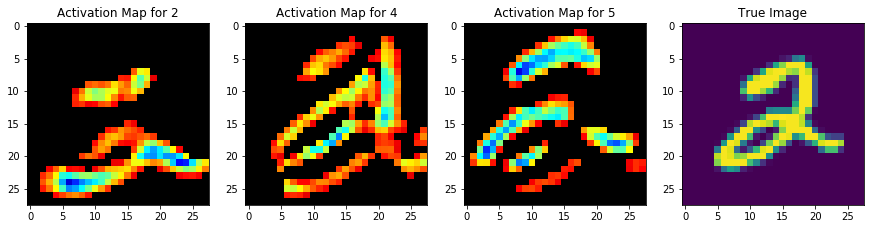

In [48]:
new_img = heatmap*0.5 + img
final_img = new_img.reshape((28,28,3))

imgs = [heatmap, img.reshape(28,28)]
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 15))
axes[0].imshow(heatmap)
axes[0].set_title("Activation Map for 2")
axes[1].imshow(false_heatmap)
axes[1].set_title("Activation Map for 4")
axes[2].imshow(false2_heatmap)
axes[2].set_title("Activation Map for 5")
axes[3].imshow(img.reshape((28,28)))
axes[3].set_title("True Image")